In [2]:
!pip install opencv-python imageio gdown

In [6]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y

  Successfully uninstalled tensorflow-2.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.6 MB/s eta 0:00:00


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import gdown
from typing import List


In [3]:
print(tf.__version__)

2.15.0


In [4]:
physical_devices=tf.config.list_physical_devices('pu')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

DATA LOADING

In [5]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7ecb92ce-ded2-42ae-ad7f-c4479c559c66
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 206MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # Resize the frame to a fixed size (e.g., 46x140)
        frame = tf.image.resize(frame[190:236,80:220,:], [46, 140]) # Resize frames to (46, 140)
        frames.append(frame)
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    frames = tf.stack(frames, axis=0)
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows, removing the hardcoded extension
    file_name = os.path.basename(path).split('.')[0]  # Use os.path.basename for cross-platform compatibility
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align') # Now alignment_path is correctly constructed
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [11]:
test_path = './data/s1/bbal6n.mpg' # Changed the test_path
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbal6n'

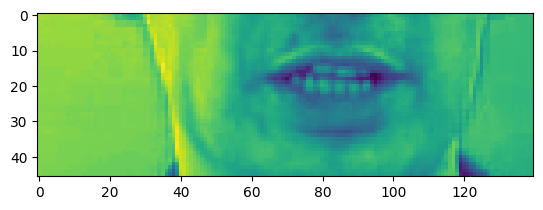

In [12]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[40])


In [13]:
alignments


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [14]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

DATA PIPELINE

In [16]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
# Adjust padded_batch to avoid zero-padding in the temporal dimension
data = data.padded_batch(2, padded_shapes=([None, 46, 140, 1], [40])) # Padding is now applied to the time dimension (None)
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [17]:
len(test)

50

In [18]:
frames, alignments = data.as_numpy_iterator().next()

In [19]:
len(frames)

2

In [20]:
sample = data.as_numpy_iterator()

In [21]:
val = sample.next(); val[0]


array([[[[[ 1.227433  ],
          [ 1.227433  ],
          [ 1.227433  ],
          ...,
          [ 0.14360803],
          [ 0.17747755],
          [ 0.17747755]],

         [[ 1.227433  ],
          [ 1.227433  ],
          [ 1.227433  ],
          ...,
          [ 0.17747755],
          [ 0.17747755],
          [ 0.17747755]],

         [[ 1.1258245 ],
          [ 1.1258245 ],
          [ 1.1258245 ],
          ...,
          [ 0.17747755],
          [ 0.07586896],
          [ 0.07586896]],

         ...,

         [[ 0.8548682 ],
          [ 0.8548682 ],
          [ 0.8548682 ],
          ...,
          [-0.26282632],
          [-0.19508727],
          [-0.36443493]],

         [[ 0.8209986 ],
          [ 0.8209986 ],
          [ 0.8209986 ],
          ...,
          [-0.49991304],
          [-0.26282632],
          [-0.5337826 ]],

         [[ 0.8209986 ],
          [ 0.8209986 ],
          [ 0.8209986 ],
          ...,
          [-0.8047388 ],
          [-0.29669586],
          

In [22]:
import numpy as np
import imageio

def find_last_valid_frame(frames):
    """Finds the index of the last valid frame (non-zero) in a sequence of frames."""
    for i in range(len(frames) - 1, -1, -1):
        if np.any(frames[i]):  # Check if the frame has any non-zero values
            return i + 1  # Add 1 for the actual frame
    return 0  # If the loop has run to the end, return 0

# Get the frames and alignments from your data generator
frames, alignments = next(data.as_numpy_iterator())

# Iterate through the batch
for batch_index in range(frames.shape[0]):  # Assuming batch size of 2
    # Extract frames for the current batch element
    batch_frames = frames[batch_index]

    # Find the index of the last valid frame (non-zero)
    last_valid_frame = find_last_valid_frame(batch_frames)

    # Select only valid frames
    valid_frames = batch_frames[:last_valid_frame]

    # Convert frames to uint8 for imageio.mimsave
    # Squeeze the extra dimension and ensure the data type is uint8
    frames_uint8 = [np.uint8(frame.squeeze() * 255) for frame in valid_frames]

    # Save as GIF using the batch index in the filename
    imageio.mimsave(f'./animation_{batch_index}.gif', frames_uint8, fps=10)

In [23]:
import numpy as np
import imageio


# Get the frames and alignments from your data generator
frames, alignments = next(data.as_numpy_iterator())

# Access the frames correctly, it's val[0] not val[0][1]
frames_to_save = val[0][0] # Assuming you want to save frames from the first element of the batch

# Find the index of the last valid frame (non-zero)
last_valid_frame = find_last_valid_frame(frames_to_save)

# Select only valid frames
valid_frames = frames_to_save[:last_valid_frame]

# Convert frames to uint8 for imageio.mimsave
# Squeeze the extra dimension and ensure the data type is uint8
frames_uint8 = [np.uint8(frame.squeeze() * 255) for frame in valid_frames]

# Save as GIF
imageio.mimsave('./animation.gif', frames_uint8, fps=10)

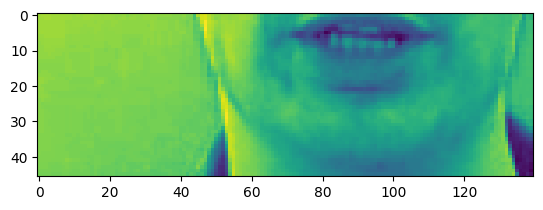

In [24]:
plt.imshow(val[0][0][35])

In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with o zero now'>

DEEP NEURAL NETWORK

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [30]:
yhat = model.predict(val[0])

1/1 [==============================] - 11s 11s/step


In [31]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'qqqqqqqqqqq7777777777777777777777777777777777777777qqqqqqqqqqqqqqqq1111117'>

In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'qqqqqqqqqqq7777777777777777777777777777777777777777qqqqqqqqqqqqqqqq1111117'>

In [33]:
model.input_shape


(None, 75, 46, 140, 1)

In [34]:
model.output_shape


(None, 75, 41)

Setup Training Options and Train

In [45]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
model.compile(optimizer=legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=80, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 100.8874

PREDICTION

In [51]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=b47ee389-e3f7-447d-abcb-f7c7de2adef1
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 246MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [89]:
model.load_weights('/content/models/checkpoint')  # Updated path

In [90]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 [==============================] - 10s 10s/step


In [91]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green at i nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by s zero now'>]

In [92]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se ree at t hve again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'se reen in i ive again'>]

TEST ON VIDEO

In [65]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbaf5a.mpg'))
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]

In [66]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 5s 5s/step


In [67]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se ree it i ite sagain'>]

In [94]:

!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00


In [97]:
import gradio as gr
import tensorflow as tf
import numpy as np

# ... (Your existing code for data loading, model definition, etc.) ...

def predict_on_video(video_path):
    try:
        sample = load_data(tf.convert_to_tensor(video_path))
        yhat = model.predict(tf.expand_dims(sample[0], axis=0))
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
        predicted_text = tf.strings.reduce_join([num_to_char(word) for word in decoded[0]]).numpy().decode('utf-8')

        actual_text = tf.strings.reduce_join([num_to_char(word) for word in sample[1]]).numpy().decode('utf-8')
        return predicted_text, actual_text
    except Exception as e:
        return f"Error: {e}", ""

video_files = [f'/content/data/s1/{file}' for file in os.listdir('/content/data/s1') if file.endswith('.mpg')]

iface = gr.Interface(
    fn=predict_on_video,
    inputs=gr.Dropdown(choices=video_files, label="Select a video"),
    outputs=[
        gr.Textbox(label="Predicted Text"),
        gr.Textbox(label="Actual Text")
    ],
    title="Lip Reading Model",
    description="Select a video to see the predicted and actual text."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://19160a0b7a68a94aa5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
